# EDA On Wifire BP3D Runs Dataset
Key Questions: 
- What existing features are useful in predicting the run time of a wifire simulation? 
- What features can be created to assist in eventually training a prediction model?
- What is the correlation between different variables and runtime?

# Setup

In [1]:
from tqdm import tqdm
import pandas as pd
from pprint import pprint
from rich import print as show
from datetime import datetime, timedelta
import time
import seaborn as sns
import ast
from sklearn.preprocessing import MinMaxScaler

In [2]:
simulation_runs = pd.read_csv("simulation_runs.csv")
simulation_runs.columns

Index(['Unnamed: 0', 'path', 'time_scraped', 'canopy_moisture', 'dz', 'extent',
       'extent_fmt', 'fire_grid', 'fuel', 'ignition', 'output', 'resolution',
       'resolution_units', 'run_binary', 'run_end', 'run_max_mem_rss_bytes',
       'run_start', 'seed', 'sim_time', 'surface_moisture', 'threads',
       'timestep', 'topo', 'wind_direction', 'wind_speed'],
      dtype='object')

In [349]:

def calculate_area(str):
    #where p1 in the bottom left = (x1,y1) and p2 in the bottom left = (x2,y2)
    L = ast.literal_eval(str)
    x1, y1, x2, y2 = float(L[0]), float(L[1]), float(L[2]), float(L[3])
    
    area = (x2-x1) * (y2-y1)
    return abs(area)


# DataFrame Reshaping
add area column generated from `extent` and only extract relevant columns

In [350]:
useful_columns = [
    "sim_time",
    # "run_end",
    # "run_start",
    # "output",
    "extent",
    "surface_moisture",
    "timestep",
    "wind_direction",
    "wind_speed",
    "canopy_moisture",
]
run_data = simulation_runs.get(useful_columns)
column = run_data.apply(lambda row: calculate_area(row["extent"]), axis=1)
run_data = run_data.assign(area=column)

# steps_fire = run_data.apply(lambda row: row["output"] ? ast.literal_eval(row["output"])["steps_fire"] : None, axis=1)
# run_data = run_data.assign(steps_fire=column)

run_data.head()
# import ast
# for i in range(0,1000):
#     try:
#         a = ast.literal_eval(run_data["output"][i])

#         print(a["steps_fire"],end=", ")
#     except ValueError:
#         print("a is ", a)
run_data = run_data.drop(columns="extent")

In [351]:
print(run_data.shape)
duplicate_rows_df = run_data[run_data.duplicated()]
print("number of duplicate rows: ", duplicate_rows_df.shape)
run_data = run_data.drop_duplicates()

run_data.count()

(1806, 7)
number of duplicate rows:  (343, 7)


sim_time            1463
surface_moisture    1463
timestep            1463
wind_direction      1463
wind_speed          1463
canopy_moisture     1463
area                1463
dtype: int64

In [352]:
run_data.describe()

,sim_time,surface_moisture,timestep,wind_direction,wind_speed,canopy_moisture,area
count,1463.000000,1463.000000,1463.000000,1463.000000,1463.000000,1463.000000,1.463000e+03
mean,9168.996582,0.130273,587.232399,148.684211,4.845910,0.886692,8.822451e+05
std,6521.347437,0.065308,84.160638,87.490223,3.545049,0.224808,6.136312e+05
min,10.000000,0.000000,1.000000,-29.000000,1.000000,0.000000,2.948400e+05
25%,4503.000000,0.090000,600.000000,90.000000,2.235000,0.900000,5.609760e+05
50%,6748.000000,0.100000,600.000000,120.000000,4.470000,0.900000,6.480240e+05
75%,11382.000000,0.150000,600.000000,225.000000,6.705000,1.000000,8.208640e+05
max,88166.000000,0.330000,600.000000,360.000000,25.000000,1.200000,6.051040e+06


<Axes: >

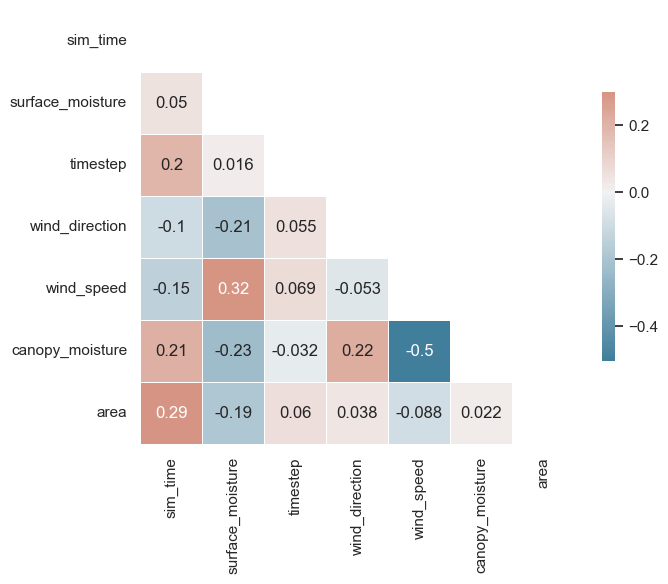

In [353]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Compute the correlation matrix
corr = run_data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

[]

<Figure size 1500x1000 with 0 Axes>

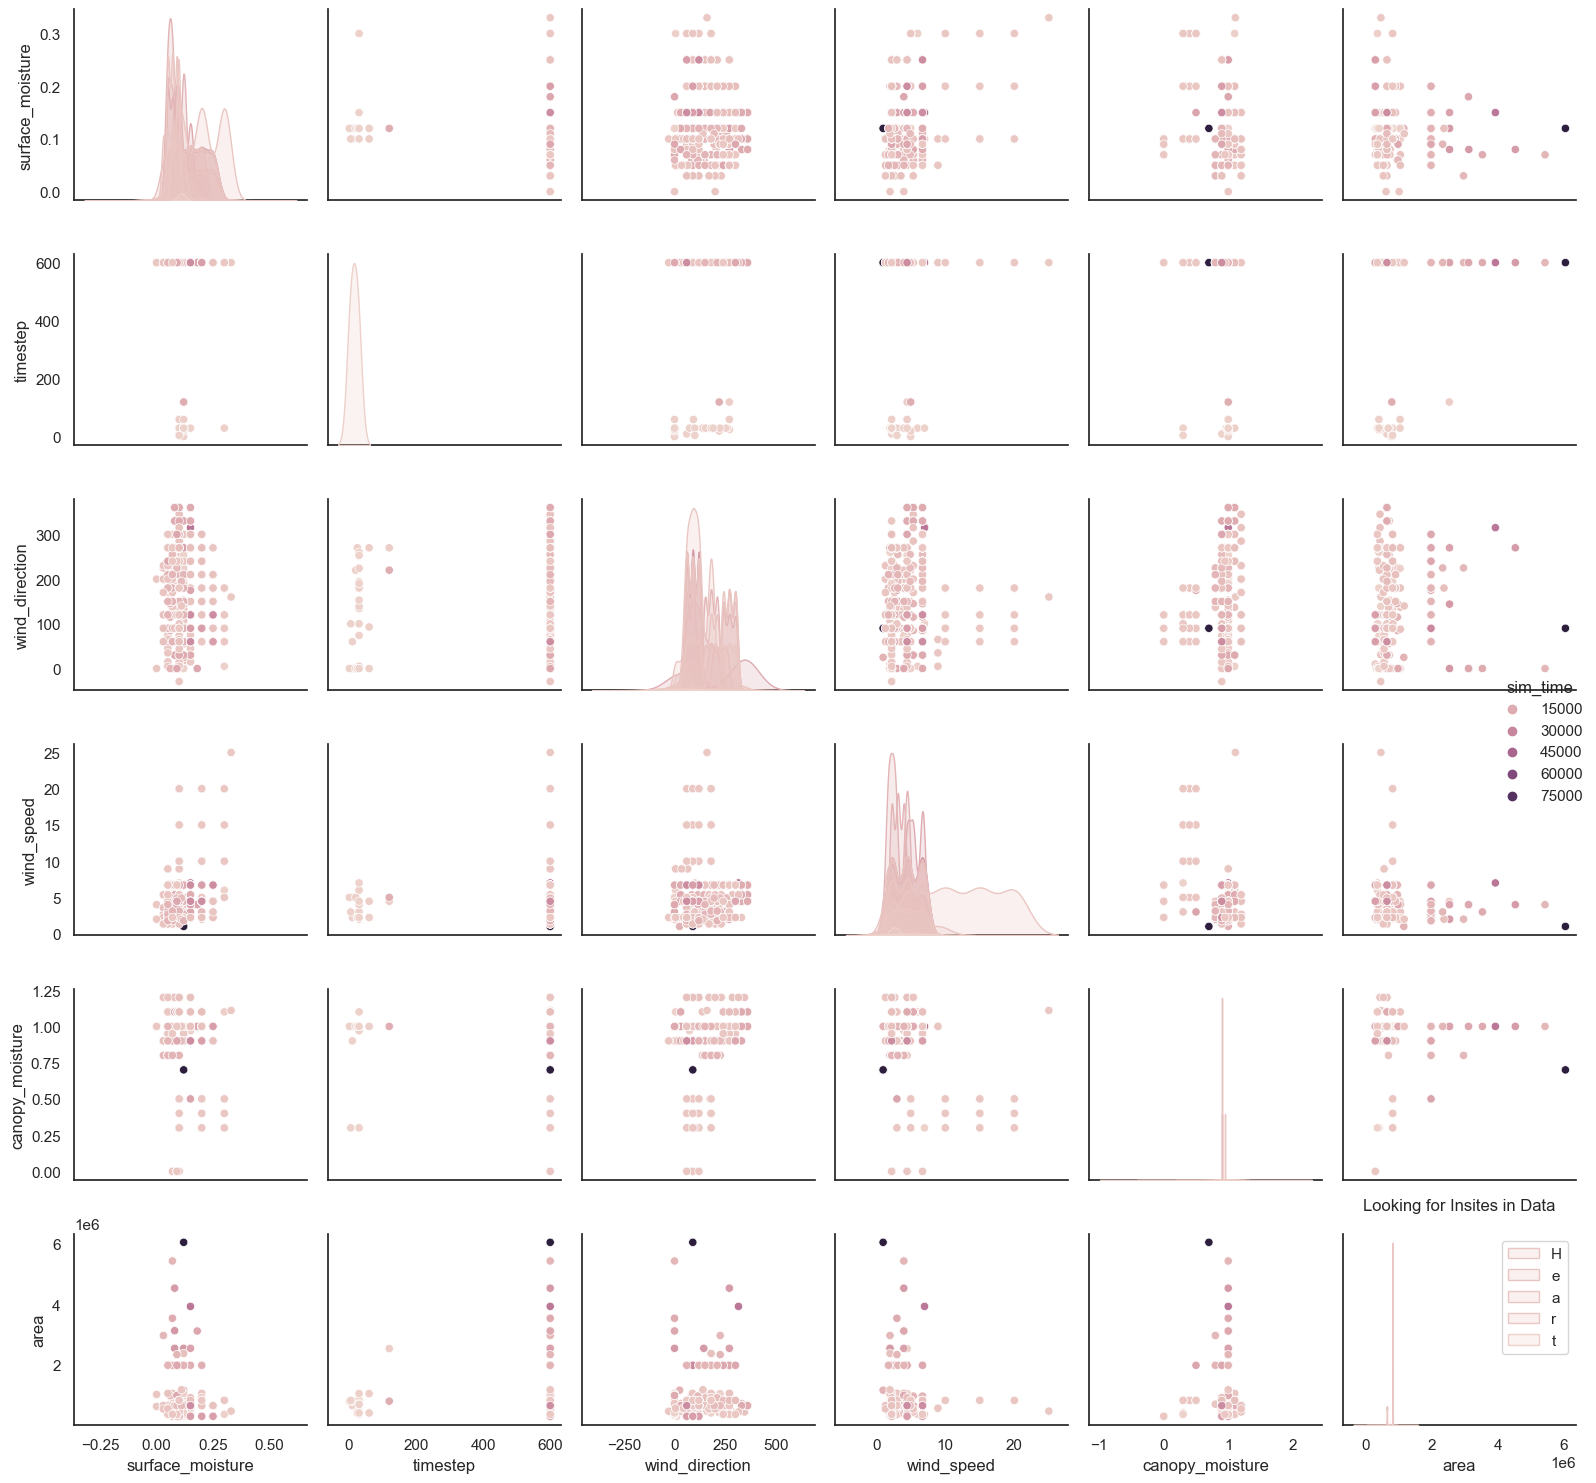

In [354]:
plt.figure(figsize=(15,10))
sns.pairplot(run_data,hue="sim_time")
plt.title("Looking for Insites in Data")
plt.legend("HeartDisease")
plt.tight_layout()
plt.plot()

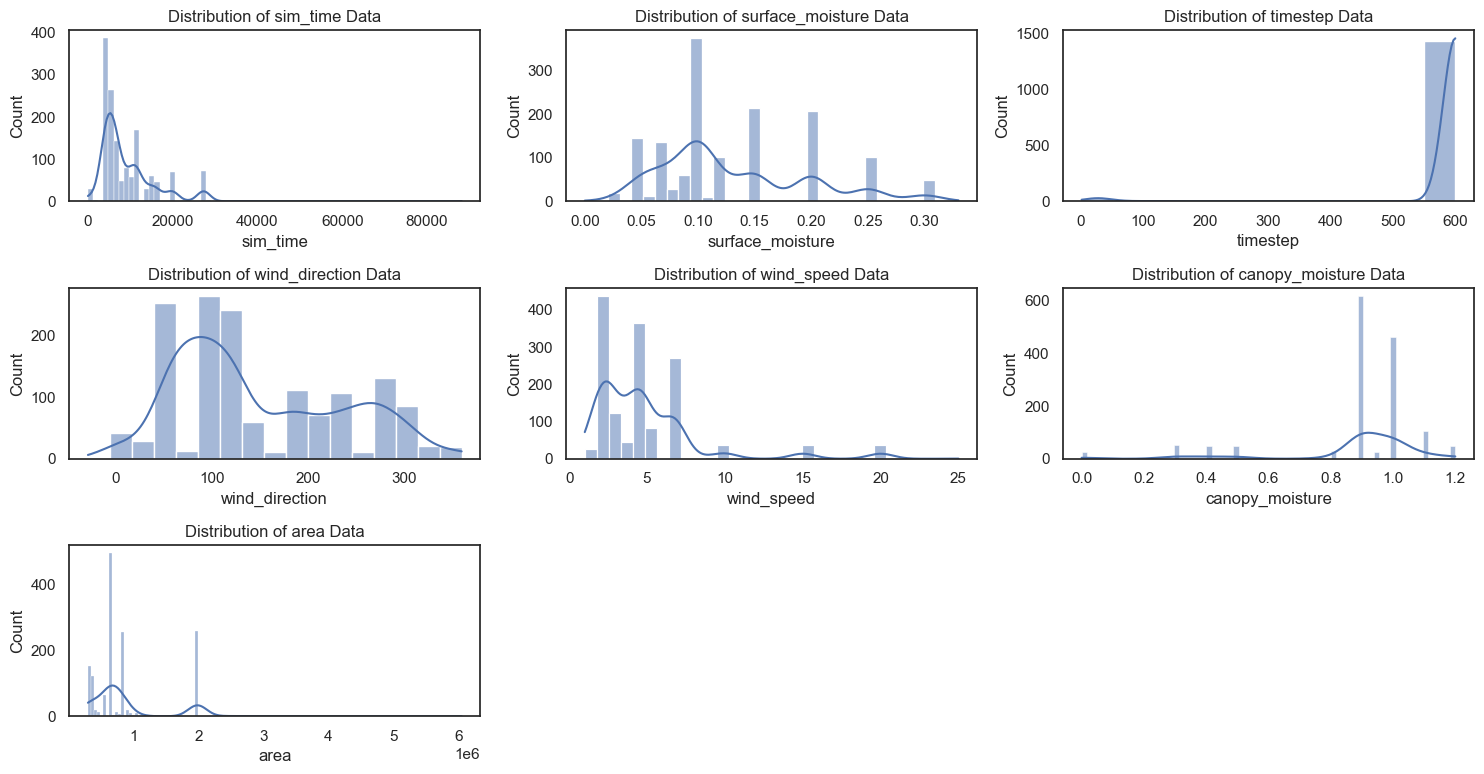

In [355]:
plt.figure(figsize=(15,10))
for i,col in enumerate(run_data.columns,1):
    plt.subplot(4,3,i)
    plt.title(f"Distribution of {col} Data")
    sns.histplot(run_data[col],kde=True)
    plt.tight_layout()
    plt.plot()

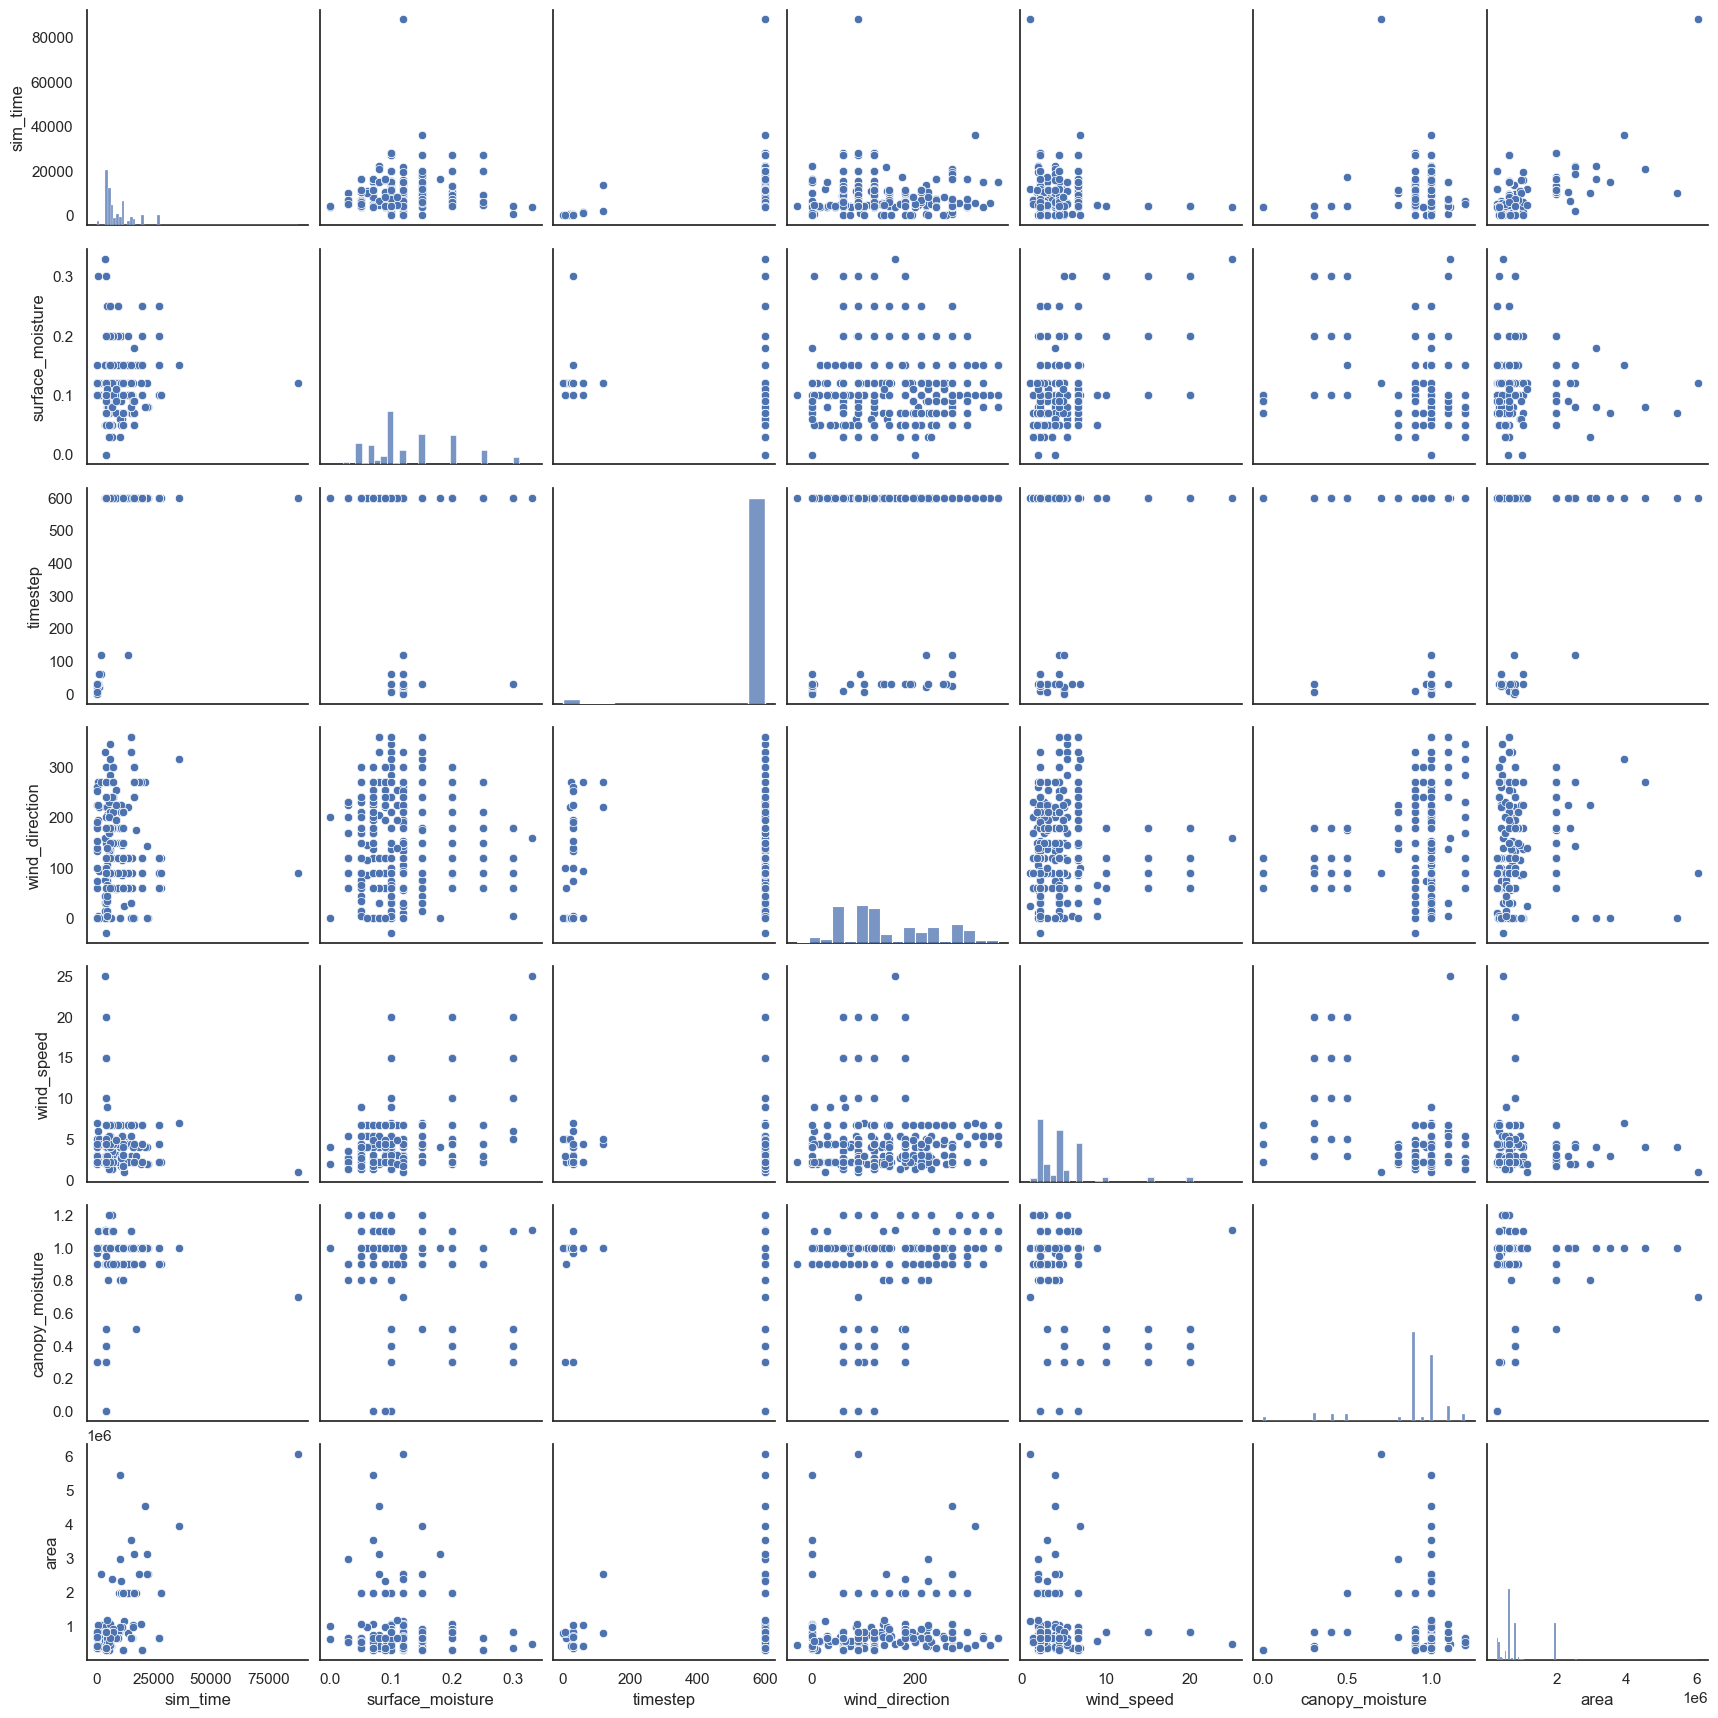

In [356]:
sns.pairplot(run_data)

In [357]:
# run_data = run_data.dropna(subset= "output")
# run_data.count()
run_data.isnull().sum()

sim_time            0
surface_moisture    0
timestep            0
wind_direction      0
wind_speed          0
canopy_moisture     0
area                0
dtype: int64

# Normalize

In [358]:
def normalize(series):
    return MinMaxScaler().fit_transform(np.array(series).reshape(-1,1))

In [359]:
run_data['area'] = normalize(run_data['area'])
run_data['surface_moisture'] = normalize(run_data['surface_moisture'])
run_data['timestep'] = normalize(run_data['timestep'])
run_data['wind_direction'] = normalize(run_data['wind_direction'])
run_data['wind_speed'] = normalize(run_data['wind_speed'])

run_data.head()

,sim_time,surface_moisture,timestep,wind_direction,wind_speed,canopy_moisture,area
0,4503,0.10,600,65.0,2.235,1.00,560976.0
1,11382,0.05,600,90.0,4.470,0.90,1981888.0
2,3937,0.12,600,270.0,2.235,0.95,359488.0
3,4921,0.10,600,137.0,3.000,1.10,1053216.0
4,14997,0.15,600,360.0,4.470,1.00,648024.0


# K means clustering

In [365]:
# print(test_y.head())
# test_X.head()

,area,surface_moisture,wind_direction,wind_speed,canopy_moisture
1357,820864.0,0.20,180.0,10.000,0.5
1359,646416.0,0.20,60.0,4.470,1.0
1360,648024.0,0.10,330.0,5.364,1.0
1361,294840.0,0.10,120.0,4.470,0.9
1362,1981888.0,0.15,175.0,3.000,0.5


In [374]:
import numpy as np
from sklearn import datasets
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import sklearn.metrics as sm

In [375]:
df = run_data[:800] # only look at a little bit of data for now

X = df.get(['area','surface_moisture','wind_direction','wind_speed','canopy_moisture'])
y = pd.DataFrame(df['sim_time'], columns=['sim_time'])

In [376]:
n_clusters = 30
model = KMeans(n_clusters=n_clusters)
model.fit(X)

KMeans(n_clusters=30)

In [377]:
from random import randint
tdf = run_data[-200:]
test_X = tdf.get(['area','surface_moisture','wind_direction','wind_speed','canopy_moisture'])
test_y = pd.DataFrame(tdf['sim_time'], columns=['sim_time'])

In [378]:
prediction = model.predict(test_X)

In [379]:
test_y["sim_time"] = (test_y["sim_time"] / test_y["sim_time"].max()) * n_clusters

test_y
d = pd.DataFrame({},columns=["answer","prediction"])
d["answer"] = test_y
d["prediction"] = prediction
d["difference"] = abs(d["answer"] - d["prediction"])


In [380]:
accuracy = 1 - (d["difference"].sum() / len(d) / n_clusters) 
print(f"{round(accuracy * 100,1)}% accurate")

70.5% accurate


In [381]:
len(run_data)

1463

# Linear Regression

In [382]:
import numpy as np
from sklearn.linear_model import LinearRegression
x = run_data
y = np.array(run_data['sim_time'])
x

,sim_time,surface_moisture,timestep,wind_direction,wind_speed,canopy_moisture,area
0,4503,0.10,600,65.0,2.235000,1.00,560976.0
1,11382,0.05,600,90.0,4.470000,0.90,1981888.0
2,3937,0.12,600,270.0,2.235000,0.95,359488.0
3,4921,0.10,600,137.0,3.000000,1.10,1053216.0
4,14997,0.15,600,360.0,4.470000,1.00,648024.0
5,27251,0.25,600,90.0,2.235000,0.90,648024.0
6,16374,0.05,600,270.0,2.235000,1.00,1981888.0
7,5983,0.15,600,180.0,4.470000,0.90,648024.0
8,5945,0.10,600,120.0,6.705000,1.00,646416.0
9,8543,0.09,600,195.0,3.129000,0.90,648024.0


In [383]:
model = LinearRegression().fit(x, y)

In [384]:
r_sq = model.score(x, y)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model.intercept_}")
print(f"coefficients: {model.coef_}")

coefficient of determination: 1.0
intercept: -1.2732925824820995e-11
coefficients: [ 1.00000000e+00  1.66563589e-13 -2.58262294e-16  9.76202383e-16
  8.63597525e-15  2.32316742e-14  9.82238307e-18]


In [385]:
y_pred = model.predict(x)
print(f"predicted response:\n{y_pred}")
a = [i for i in range(len(y))]
len(a)

predicted response:
[ 4503. 11382.  3937. ... 11359.  3937. 27251.]


1463

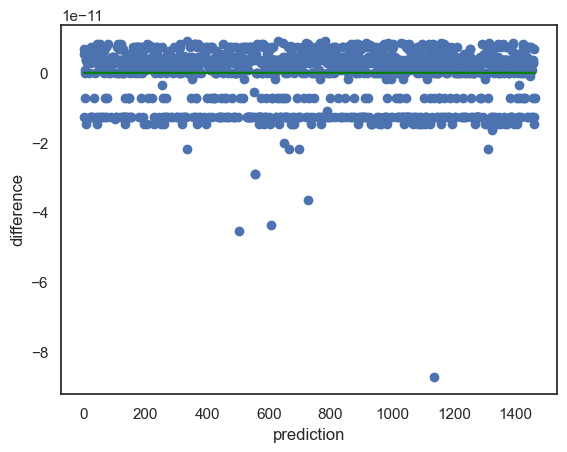

In [386]:
plt.scatter(a,y-y_pred)
plt.xlabel("prediction")
plt.ylabel("difference")
plt.plot(a, [0 for i in y_pred], color="green")        